# Validation comparing queried articles with random articles

### Sagar Setru, September 21th, 2020

In [1]:
# make sure I'm in the right environment (should be 'debiaser')
import os
print('Conda environment:')
print(os.environ['CONDA_DEFAULT_ENV'])

Conda environment:
debiaser


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import json

# NLP Packages
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# to break articles up into sentences
from nltk import tokenize

import pyLDAvis
import pyLDAvis.gensim

import pickle

from debiaser_validation_function import return_suggested_articles2
# from text_processing_functions import process_all_articles
# from text_processing_functions import remove_stopwords
# from text_processing_functions import get_simple_corpus_dictionary_bow
# from text_processing_functions import entity_recognizer
# from text_processing_functions import get_topic_words_mean_std_prob_frequency
# from text_processing_functions import sort_topics_mean_frequency

import pickle
print('DONE')

DONE


In [6]:
def get_jaccard_sim(list1, list2): 
    """
    fxn calculates jaccard sim between two lists of words
    from https://towardsdatascience.com/overview-of-text-similarity-metrics-3397c4601f50
    """
    a = set(list1) 
    b = set(list2)
    
    c = a.intersection(b)
    
    return float(len(c)) / (len(a) + len(b) - len(c))

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# these were identified with 5 words

# list of main urls
url_main = [
    'https://www.nytimes.com/2020/09/30/health/covid-cruise-ships.html'
]

urls_queried = [
    'https://abcnews.go.com/Health/wireStory/crew-member-cruise-ship-virus-cases-dies-florida-70073196',
    'https://abcnews.go.com/International/wireStory/german-cruise-ship-sets-sail-hopes-short-trip-71986996',
    'https://apnews.com/article/dbc1f2f76ec33ad06d0a78c4ca3e774a',
    'https://apnews.com/article/ap-top-news-travel-international-news-changing-economy-travel-e9878e281e71d58a6bd4e7f88a24797d',
    'https://www.breitbart.com/news/german-cruise-ship-sets-sail-hopes-short-trip-thwarts-virus/',
    'https://www.forbes.com/sites/alexledsom/2020/09/30/white-house-blocks-cdcs-idea-to-extend-no-sail-order-until-feb-2021/#3e2381e73e42',
    'https://www.foxnews.com/travel/cdc-extends-no-sail-order-cruise-ships-coronavirus-crisis',
    'https://www.foxnews.com/travel/zaandam-cruise-ship-fourth-person-coronavirus-dies',
    'https://www.theguardian.com/us-news/2020/oct/01/florida-keys-cruise-ship-ban-covid-19',
    'https://thehill.com/policy/transportation/518975-white-house-blocked-extending-no-sail-cruise-ship-order-until-february',
    'https://thehill.com/policy/healthcare/486115-second-princess-cruise-ship-with-possible-coronavirus-onboard-held-offshore',
    'https://www.nbcnews.com/health/health-news/live-blog/2020-04-09-coronavirus-news-n1179786/ncrd1180841#blogHeader',
    'https://www.nytimes.com/2020/09/30/health/covid-cruise-ships.html',
    'https://www.nytimes.com/2020/09/30/briefing/presidential-debate-cruise-ships-nba.html',
    'https://www.newsmax.com/world/globaltalk/germany-virus-outbreak-cruises/2020/07/25/id/979000/',
    'https://www.npr.org/sections/coronavirus-live-updates/2020/10/01/919082224/the-cdc-extends-no-sail-order-for-cruise-lines',
    'https://www.npr.org/sections/coronavirus-live-updates/',
    'https://reason.com/video/how-china-corrupted-the-world-health-organizations-response-to-covid-19/',
]

urls_random = [
    'https://abcnews.go.com/Health/wireStory/australia-expects-covid-19-vaccination-year-73467063',
    'https://abcnews.go.com/Politics/wireStory/questions-pence-harris-prepare-debate-faceoff-73458831',
    'https://apnews.com/article/election-2020-virus-outbreak-joe-biden-donald-trump-campaigns-3e201de86931e092efb31de0284ed67e',
    'https://apnews.com/article/virus-outbreak-india-archive-economy-a6b30f224b37015e982fd557dcf522d5',
    'https://www.breitbart.com/economy/2020/10/06/pelosi-killed-the-bill/',
    'https://www.forbes.com/sites/lanabandoim/2020/10/06/tally-the-cute-shelf-scanning-robot-is-coming-to-more-grocery-stores/#6105129e177f',
    'https://www.foxnews.com/sports/patriots-james-white-fathers-tragic-death-meant-whole-lot',
    'https://www.foxnews.com/sports/acuna-hr-plunked-again-braves-top-marlins-9-5-to-open-nlds',
    'https://www.theguardian.com/environment/2020/oct/07/one-guy-pulled-a-crowbar-on-me-why-fly-tipping-wars-are-raging-across-britain',
    'https://thehill.com/policy/energy-environment/519909-biden-would-face-hurdles-undoing-trump-environmental-rollbacks',
    'https://thehill.com/homenews/campaign/519851-trump-biden-tied-when-it-comes-to-economy-poll',
    'https://www.nbcnews.com/news/us-news/justice-department-officials-drove-family-separation-policy-watchdog-report-says-n1242375',
    'https://www.nytimes.com/2020/10/07/nyregion/register-to-vote-nyc.html',
    'https://www.nytimes.com/2020/10/06/nyregion/graffiti-artists-5pointz.html',
    'https://www.newsmax.com/politics/stephen-miller-covid-19-testing-positive/2020/10/06/id/990703/',
    'https://www.npr.org/2020/10/07/921055011/trumps-covid-19-treatment-hangs-over-vice-presidential-debate',
    'https://www.npr.org/2020/10/06/920684113/michelle-obama-makes-final-pitch-vote-for-joe-biden-like-your-lives-depend-on-it',
    'https://reason.com/2020/10/06/eddie-van-halen-melting-pot-virtuoso/',
]

# no hits: aljazeera, atlantic, bbc, buzzfeed, cbn, cbs, democracy now, factcheck, huffpost, national review, reuters, salon

# fails for nearly same event: newsmax, wsj

#     https://nypost.com/2020/04/10/cdc-extends-no-sail-order-for-all-cruises-amid-coronavirus-crisis/
#     https://nypost.com/2020/07/16/cdc-bans-us-cruises-through-september-due-to-ongoing-outbreaks-on-ships/

# doesn't work: CNN, daily beast, msnbc, nypost, spectator
# buggy: mother jones, newsmax, politico, salon

/Users/sagarsetru/anaconda3/envs/debiaser/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# get query words from original article
url_main_query_words = return_suggested_articles2(url_main[0])

# arrays for jaccard sim results
jaccard_sim_queried_articles = np.zeros((len(urls_queried),1))
jaccard_sim_random_articles = np.zeros((len(urls_queried),1))

In [51]:
# get jaccard sim scores between queried articles and main article

for ind, url in enumerate(urls_queried):
    
    # get query words
    query_words = return_suggested_articles2(url,num_lda_topics=1)
    
    print(f'query words: {query_words[0]}')
    jaccard_sim = get_jaccard_sim(url_main_query_words[1],query_words[1])
    
    jaccard_sim_queried_articles[ind] = jaccard_sim
    
print('DONE')

AFTER STOPWORDS
[['crew', 'cruise', 'ship', 'virus', 'cases', 'dies', 'florida'], ['miami', 'crew', 'hospitalized', 'ill', 'fated', 'cruise', 'ships', 'coronavirus', 'patients', 'dock', 'florida', 'broward', 'examiner', 'craig', 'mallak', 'wiwit', 'widarto', 'indonesia'], ['widarto', 'tested', 'positive', 'covid', 'raising', 'zaandam', 'ship', 'coronavirus', 'toll', 'zaandam', 'sister', 'ship', 'docked', 'fort', 'lauderdale', 'port', 'spending', 'sea', 'rejected', 'ports', 'holland', 'erik', 'elvejord'], ['florida', 'ship', 'docked', 'elderly', 'passengers', 'cruise', 'ships', 'arrived', 'examiner', 'tested', 'positive', 'covid'], ['caused', 'viral', 'infection'], ['mallak', 'tested', 'negative', 'virus', 'examined', 'passengers', 'disembarked', 'zaandam', 'sister', 'ship', 'rotterdam', 'replenish', 'supplies', 'crew', 'falling', 'ill'], ['cruise', 'florida', 'negotiated', 'allowing', 'disembarkation', 'cruise', 'passengers', 'kept', 'aboard', 'mildly', 'ill', 'scheduled', 'charter', '

AFTER STOPWORDS
[['blocks', 'cdc', 'extend', 'sail', 'feb'], ['coral', 'princess', 'docked', 'miami', 'passengers', 'crew', 'aboard', 'tested', 'positive', 'covid'], ['cruise', 'sail'], ['disease', 'prevention', 'cdc', 'fighting', 'extend', 'feburary', 'overruled', 'extension', 'extended', 'october', 'pandemic', 'cruise', 'experiencing', 'uk', 'ireland', 'telegraph', 'passenger', 'numbers', 'accounted', 'annually', 'highest', 'eu', 'germany', 'ships', 'launch', 'richard', 'branson', 'scarlet', 'lady', 'costing', 'maiden', 'voyage', 'postponed', 'cdc', 'slammed', 'cruise', 'allowing', 'rapid', 'infection', 'travelers', 'aboard', 'ships', 'pandemic'], ['cdc', 'stated', 'managing', 'outbreaks', 'ships', 'pandemic', 'cruise', 'ships', 'minds', 'carnival', 'diamond', 'princess', 'suffered', 'outbreak', 'infected', 'mooring', 'yokohama', 'harbor', 'japan'], ['operations', 'mostly', 'standstill', 'travelers', 'stranded'], ['carnival', 'quarterly', 'losses', 'mid', 'diamond', 'princess', 'crui

AFTER STOPWORDS
[['island', 'cruise', 'ships', 'florida', 'keys'], ['thu', 'oct', 'edt', 'modified', 'thu', 'oct', 'edtwill', 'benson', 'stands', 'platform', 'mint', 'green', 'fishing', 'boat', 'hot', 'sun', 'whipsaws', 'fly', 'fishing', 'rig', 'azure', 'waters', 'glassy', 'aquarium'], ['feet', 'deep'], ['dreadlock', 'holiday', 'plays', 'radio'], ['luke', 'watches', 'lets', 'lure', 'fly', 'wheeeeeeeeesh'], ['sails', 'silhouettes', 'nurse', 'sharks', 'lemon', 'shark', 'immediate', 'elusive', 'permit', 'sparking', 'bites'], ['roll', 'silvery', 'fins', 'glancing', 'surface', 'stretch', 'paradise', 'florida', 'keys', 'marine', 'sanctuary', 'cruise', 'ship', 'plowed', 'shallow', 'heavily', 'channel', 'locals', 'relative', 'peace', 'waters', 'residents', 'cruise', 'ships', 'benson'], ['reality', 'destroying', 'environment', 'keys', 'benson', 'boat', 'window', 'pane', 'fishing', 'guide', 'keys', 'guides', 'association'], ['pole', 'luke', 'magic', 'touch', 'luke', 'mon', 'covid', 'keys', 'lock

TIME FOR LDA MODEL GENERATION
0.045474000000002235
query words:  saving redfield cdc guests cruise
AFTER STOPWORDS
[['princess', 'cruise', 'ship', 'coronavirus', 'onboard', 'offshore', 'san', 'francisco'], ['princess', 'cruise', 'ship', 'grand', 'princess', 'reportedly', 'shore', 'san', 'francisco', 'discovered', 'links', 'deadly', 'coronavirus', 'onboard', 'ship', 'returned', 'san', 'francisco', 'crew', 'passengers', 'coronavirus', 'symptoms', 'los', 'angeles', 'passengers', 'interviewed', 'princess', 'cruises', 'lax', 'screenings', 'boarding', 'ship', 'inform', 'customers', 'factors', 'california', 'gov'], ['gavin', 'newsomgavin', 'newsomactivists', 'gather', 'california', 'jails', 'mass', 'clemency', 'covid', 'spread', 'newsom', 'nominates', 'openly', 'gay', 'serve', 'california', 'supreme', 'california', 'carbon', 'mandate', 'emissions', 'declared', 'statewide', 'emergency', 'coronavirus', 'passenger', 'pre', 'existing', 'conditions', 'exposed', 'virus', 'passenger', 'grand', 'prin

AFTER STOPWORDS
[['blocked'], ['cruise', 'ships', 'docked'], [], ['sail', 'extended', 'upset', 'tourism', 'crucial', 'swing', 'florida', 'blocked', 'centers', 'disease', 'prevention', 'cruise', 'ships', 'docked', 'mid', 'displeased', 'politically', 'powerful', 'tourism', 'crucial', 'swing', 'florida', 'sail', 'originally', 'extended', 'expire'], ['dr', 'robert', 'redfield', 'recommended', 'extension', 'worried', 'cruise', 'ships', 'viral', 'hot', 'spots', 'beginning', 'pandemic', 'coronavirus', 'task', 'dr', 'redfield', 'overruled', 'authorized', 'spoke', 'condition', 'anonymity'], ['ships', 'sail', 'oct', 'agreed', 'voluntary'], ['rejection', 'original', 'axios', 'dr'], ['redfield', 'scolded', 'promoting', 'mask', 'wearing', 'cautioning', 'vaccines', 'widely', 'worried', 'fired', 'considered', 'resigning', 'required', 'oversee', 'compromised', 'dr', 'redfield', 'brian', 'morgenstern', 'deputy', 'cruise', 'ship', 'politically', 'motivated'], ['vice', 'task', 'science', 'implement', 'po

AFTER STOPWORDS
[[], ['berlin', 'german', 'cruise', 'ship', 'gingerly', 'testing', 'amid', 'coronavirus', 'pandemic', 'setting', 'sail', 'shut', 'strict', 'precautions', 'passengers', 'crew', 'safe', 'tui', 'cruise', 'ship', 'mein', 'schiff', 'literally', 'ship', 'sail', 'cruise', 'sea', 'dpa', 'occupancy', 'passengers', 'distance'], ['ship', 'sailed', 'passengers', 'compared', 'normal', 'capacity'], ['crew', 'ship', 'sailed', 'northern', 'port', 'hamburg', 'toward', 'norway', 'passengers', 'spend', 'sea', 'stops', 'returning', 'germany', 'passengers', 'crew', 'required', 'meters', 'feet', 'wear', 'protective', 'masks', 'serve', 'ship', 'buffet'], ['passengers', 'fill', 'questionnaire', 'boarding', 'temperatures', 'shut', 'german', 'cruise', 'ship', 'hoping', 'shorter', 'strictly', 'controlled', 'trips', 'restart', 'devastated', 'pandemic', 'standstill', 'cruise', 'ship', 'suspend', 'operations', 'stranded', 'passengers', 'crew', 'worldwide', 'aug', 'aida', 'cruise', 'operator', 'sail'

TIME FOR LDA MODEL GENERATION
1.885626000000002
query words:  coronavirus covid airlines whitmer employees
AFTER STOPWORDS
[['corrupted', 'organization', 'covid'], ['logged', 'zach', 'weissmueller', 'pmthe', 'organization', 'questionable', 'guidance', 'coronavirus', 'slow', 'communicate', 'magnitude', 'threat', 'whitewashed', 'handling', 'crisis', 'funding', 'yesterday', 'absolved', 'failures', 'confronting', 'covid'], ['doubt', 'destroyed', 'credibility', 'damaged', 'contain', 'pandemic', 'actions', 'covid', 'stemmed', 'overly', 'deferential', 'stance', 'contributor'], ['phenomenal', 'collective', 'bruce', 'aylward', 'joint', 'mission', 'handling', 'outbreak', 'tedros', 'adhanom', 'ghebreyesus', 'praised', 'rapid', 'epidemic'], ['praised', 'releasing', 'virus', 'genome', 'neglecting', 'mention'], ['transmission', 'doctors', 'suspected'], ['extreme', 'lockdown', 'wuhan', 'saved', 'scientists', 'weren', 'wuhan', 'outbreak', 'measures', 'interim'], ['praised', 'supposed', 'openness'], ['

TIME FOR LDA MODEL GENERATION
3.8028580000000005
query words:  virus taiwan flu racist coronavirus
DONE


In [52]:
for ind, url in enumerate(urls_random):
    
    # get query words
    query_words = return_suggested_articles2(url,num_lda_topics=5)
    
    print(f'query words: {query_words[0]}')
    jaccard_sim = get_jaccard_sim(url_main_query_words[1],query_words[1])
    
    jaccard_sim_random_articles[ind] = jaccard_sim
    
print('DONE')

AFTER STOPWORDS
[['expects', 'covid', 'vaccination'], ['canberra', 'considered', 'rollout', 'coronavirus', 'vaccine', 'sooner', 'mid', 'scenario', 'pandemic', 'planning', 'save', 'tens', 'billions', 'dollars', 'treasurer', 'treasury', 'departments', 'developed', 'modelling', 'assumption', 'vaccine', 'widely', 'toward', 'treasurer', 'josh', 'frydenberg', 'uncertain', 'vaccine', 'frydenberg', 'treasury', 'modelling', 'contemplate', 'vaccine', 'becoming'], ['vaccine', 'regarded', 'rolled', 'providing', 'certainty', 'households', 'businesses', 'promoting', 'consumption', 'upside', 'scenario', 'assumes', 'universities', 'vaccine'], ['hundreds', 'overseas', 'universities', 'sector', 'earners', 'currency', 'scenario', 'boost', 'activity', 'dollars', 'forecast'], ['percentage', 'fiscal', 'forecast', 'researchers', 'developing', 'covid', 'vaccines'], ['survey', 'mostly', 'canadian', 'vaccinology', 'experts', 'journal', 'internal', 'medicine', 'pessimistic', 'vaccine', 'mid', 'october', 'achieva

AFTER STOPWORDS
[['cuomo', 'restrictions', 'parts'], ['albany', 'gov'], ['andrew', 'cuomo', 'restrictions', 'coronavirus', 'hotspots', 'shutdowns', 'businesses', 'houses', 'worship', 'schools', 'effect', 'parts', 'brooklyn', 'queens', 'sections', 'orange', 'rockland', 'counties', 'binghamton', 'pennsylvania', 'border', 'planned', 'restrictions', 'nonessential', 'shutdowns'], ['limits', 'gatherings', 'restaurants', 'agudath', 'israel', 'orthodox', 'jewish', 'umbrella', 'organization', 'criticized', 'surprise', 'measure', 'limit', 'zones', 'religious', 'practices', 'targeted'], ['cuomo', 'protecting', 'saving', 'tested', 'positive', 'sept', 'compared', 'august'], ['tested', 'positive', 'testing', 'averaging', 'deaths', 'covid', 'sept', 'compared', 'spends', 'sight', 'enter', 'quarantine', 'pence', 'harris', 'poised', 'vp', 'debate', 'starkly', 'visions', 'confronting', 'escalating', 'crises', 'catastrophic', 'collapse', 'supply', 'chain', 'consequential', 'failures', 'coronavirus', 'outb

AFTER STOPWORDS
[['tally', 'cute', 'shelf', 'scanning', 'robot', 'grocery', 'stores'], ['tally', 'robot', 'schnucks', 'shop', 'schnucks', 'grocery', 'store', 'aisle', 'tally', 'shelf', 'scanning', 'robot'], ['simbe', 'robotics', 'tally', 'autonomous', 'scans', 'shelves', 'inventory', 'restocking', 'easier'], ['schnucks', 'expanding', 'robot', 'locations', 'tally', 'scan', 'products'], ['tally', 'collects', 'helps', 'retailers', 'schnucks', 'shelves', 'stocked', 'correct', 'products', 'customers'], ['amid', 'coronavirus', 'pandemic', 'tally', 'crucial', 'schnucks'], ['tally', 'track', 'inventory', 'replenishment', 'simultaneously', 'minimizing', 'spend', 'aisles', 'keeping', 'customers', 'safe', 'brad', 'bogolea', 'founder', 'ceo', 'simbe', 'robotics', 'tally', 'removes', 'mundane', 'dreaded', 'task', 'manual', 'inventory', 'checking'], ['frees', 'teams', 'pens', 'clipboards', 'helping', 'customers', 'keeping', 'store', 'clean', 'tally', 'schnucks', 'reduction', 'items', 'stock', 'robot

AFTER STOPWORDS
[['guy', 'pulled', 'crowbar', 'fly', 'tipping', 'wars', 'raging', 'britain'], ['illegal', 'dumping', 'increased', 'lockdown', 'causing', 'fury', 'upset', 'everywhere', 'animal', 'shelters', 'villages'], ['matters', 'handsthe', 'garden', 'graceful', 'arc', 'rolling', 'twice', 'screen', 'miraculously', 'unsmashed'], ['tyre', 'door', 'frame', 'drawer', 'miscellaneous', 'pieces', 'wood', 'bits', 'hoarding', 'appears', 'voice', 'anger'], ['asks', 'filming', 'mobile'], ['owner', 'responds', 'clifford', 'hamilton', 'flinging', 'rubbish', 'garden', 'aid', 'workmen'], ['steps', 'rubbish', 'door', 'planks', 'wood', 'kitchen', 'cabinet', 'sails', 'irresponsible', 'door', 'neighbour', 'hamilton', 'bellows', 'proclaims', 'innocence'], ['jab', 'fingers', 'angrily'], ['arrive'], ['calm', 'throwing', 'pleads'], ['yelling', 'yelling'], ['handcuffs', 'hamilton', 'neighbour', 'passionately', 'pleads'], ['undignified', 'spectacle', 'amusing'], ['fly', 'tipping', 'brings', 'worst', 'hamilto

TIME FOR LDA MODEL GENERATION
0.43130000000000024
query words:  fly tippers tipping hadley rubbish
AFTER STOPWORDS
[['biden', 'hurdles', 'undoing', 'environmental', 'rollbacks'], ['biden', 'climate', 'lays', 'actions', 'implementing', 'aggressive', 'methane', 'pollution', 'limits', 'oil', 'gas', 'sector', 'developing', 'rigorous', 'fuel', 'standards', 'environmental', 'advocates', 'vice', 'target', 'effects', 'climate', 'harmful', 'marginalized', 'communities', 'complexities', 'rulemaking', 'structural', 'implemented', 'undoing', 'environmental', 'rollbacks', 'reverse', 'environmental', 'analysis'], ['replacing', 'era', 'clean', 'rule', 'reduced', 'regulatory', 'burdens', 'coal', 'fired', 'plants', 'slashing', 'mileage', 'emissions', 'standards', 'automakers', 'eliminating', 'methane', 'requirements', 'oil', 'gas', 'producers', 'analysis', 'researchers', 'rhodium', 'estimated', 'rollbacks', 'promulgated', 'extra', 'tons', 'greenhouse', 'gas', 'emissions', 'analysis', 'highlighted', 'lo

TIME FOR LDA MODEL GENERATION
0.08435099999999807
query words:  draft declined rosenstein nbc cases
AFTER STOPWORDS
[['deadlines'], ['daniel', 'slotnik'], [], ['weather', 'hat', 'blustery', 'gusts'], ['sun', 'scattered', 'shower', 'mid', 'alternate', 'parking', 'effect', 'shemini', 'atzereth'], ['amended', 'regulations', 'pandemic', 'upends', 'usual', 'crucial', 'mundane', 'civic', 'duty', 'voting'], ['yorkers', 'unaware', 'deadlines', 'register', 'request', 'absentee', 'ballot', 'voters', 'cast', 'mail', 'ballots', 'erroneous', 'absentee', 'ballots', 'brooklyn'], ['mishap', 'fodder', 'false', 'mail', 'corrupt', 'voting'], ['consult', 'guide', 'counted', 'oct'], ['yorkers', 'register', 'mail', 'oct'], ['elections', 'receive', 'mailed', 'registration', 'request'], ['forms', 'postmarked', 'oct', 'oct'], ['voters', 'request', 'absentee', 'ballots', 'fax', 'mail', 'elections', 'nov'], ['voters', 'apply', 'absentee', 'ballot', 'nov'], [], ['absentee', 'ballots', 'postmarked'], [], [], ['reg

AFTER STOPWORDS
[['michelle', 'pitch', 'joe', 'biden', 'depend'], ['continues', 'gaslight', 'acting', 'pandemic', 'threat', 'michelle', 'remarks'], ['screenshot', 'biden', 'youtube', 'hide', 'continues', 'gaslight', 'acting', 'pandemic', 'threat', 'michelle', 'remarks', 'lady', 'michelle', 'excoriated', 'aimed', 'delivering', 'closing', 'argument', 'voters', 'elect', 'joe', 'biden'], ['pretend', 'exactly', 'stands'], ['search', 'hearts', 'conscience', 'joe', 'biden', 'depend', 'biden', 'rebuked', 'sees', 'willful', 'mismanagement', 'covid', 'crisis'], ['wear', 'mask', 'consistently', 'encourage', 'actions', 'save', 'countless'], ['continues', 'gaslight', 'acting', 'pandemic', 'threat'], ['remarks', 'discharged', 'walter', 'reed', 'receive', 'treatment', 'covid', 'upon', 'mask', 'op', 'downplayed', 'severity', 'virus'], ['afraid'], ['beat', 'admonished', 'push', 'colleges', 'reopen'], ['everybody', 'kids', 'safe'], ['mom', 'frightening', 'thinking', 'babies', 'yesterday', 'quarantined',

TIME FOR LDA MODEL GENERATION
0.37349999999999994
query words:  eddie halen guitar speed born
DONE


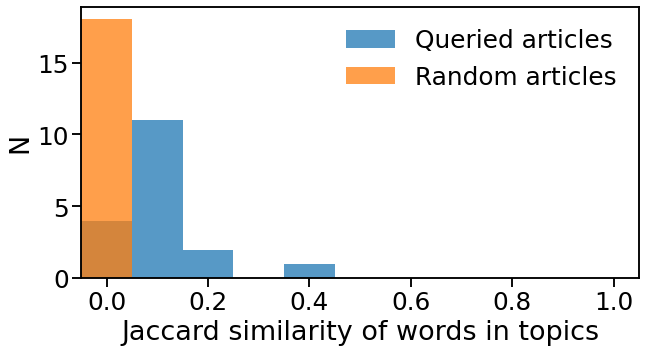

<Figure size 432x288 with 0 Axes>

In [53]:
plt.figure(figsize=(10,5));
plt.hist(jaccard_sim_queried_articles,bins=np.arange(0,1.2,.1)-.05,alpha=0.75);
plt.hist(jaccard_sim_random_articles,bins=np.arange(0,1.2,.1)-.05,alpha=0.75);
plt.ylabel('N');
plt.xlabel('Jaccard similarity of words in topics')
sns.set_context('talk', font_scale=1.5);
plt.xlim([-.05,1.05])
plt.legend(('Queried articles','Random articles'),framealpha=0)
# plt.xticks(rotation=90);
plt.show();
plt.clf();

We see that the queried articles tend to have more similar topic words, as measured by Jaccard similarity, to the initial article than random articles.